# Building an Image Recognition Neural Network

The model we'll build will use the classic MNIST dataset with handwritten numbers. We'll also cover how to construct a more robust model, make predictions, and get the meta data to determine how well the model actually performs.

In [1]:
# imports 

import numpy
import pandas
import matplotlib.pyplot as plt
import tensorflow
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU

# Setting random seeds to get reproducible results
numpy.random.seed(0)
tensorflow.random.set_seed(1)

## Reading the data

The built-in dataset is already balanced, so we don't need to worry about stratifying classes to ensure equal representation between the splits. In practice, you could use something like Sklearn's train_test_split.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training set size: 60000
Testing set size: 10000
The label is 2


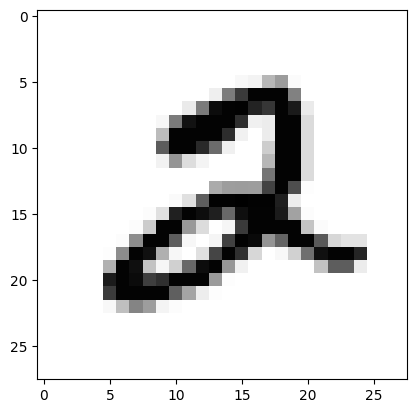

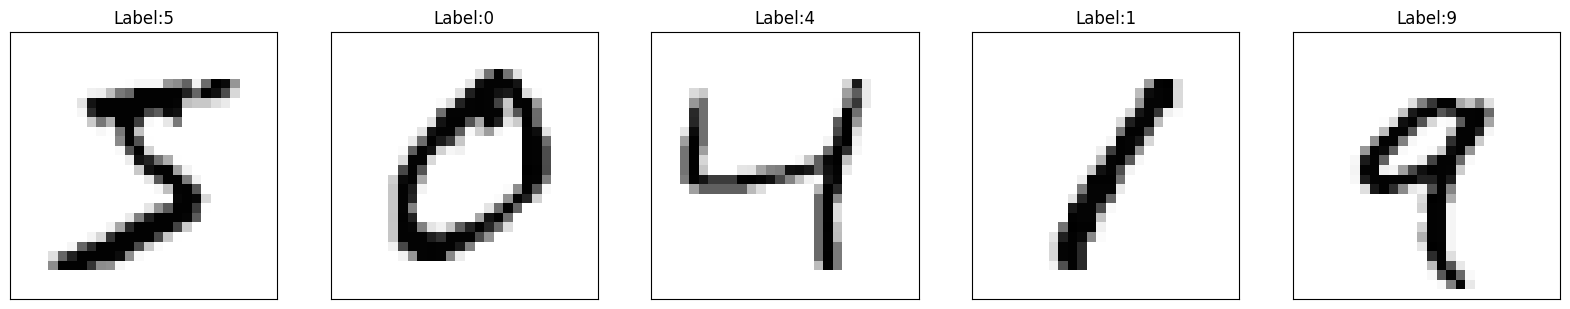

In [2]:
(x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.mnist.load_data()
print("Training set size:", len(x_train))
print("Testing set size:", len(x_test))

plt.imshow(x_train[5], cmap='Greys')
print("The label is", y_train[5])

# Plotting some examples of numbers
fig = plt.figure(figsize=(20,20))
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
    ax.imshow(x_train[i], cmap='Greys')
    ax.set_title('Label:' + str(y_train[i]))

## Pre-processing the data

We'll have to reshape the data to make it train faster, and we'll also use the pandas.factorize to ensure we get the classes despite them being synonymous with numbers.

In [3]:
# Reshaping the features
num_columns = 28*28
x_train_reshaped = x_train.reshape(-1, num_columns) # -1 is a placeholder for the dataset's size
x_test_reshaped = x_test.reshape(-1, num_columns)

# This isn't necessary since numbers are coincidentally the same as the class labels, but it's a good practice.
y_train_cat, y_train_labels = pandas.factorize(y_train, sort=True) # returns 1D array
y_test_cat, y_test_labels = pandas.factorize(y_test, sort=True) # sort to ensure class labels and numbers align

# The test and train are balanced so they should have the same number of classes
num_labels = len(set( list(y_test_labels) + list(y_test_labels))) # Add lists then use set to get unique values
assert num_labels == 10

print(x_train_reshaped.shape)
print(y_train_cat.shape) 
print(num_labels)

(60000, 784)
(60000,)
10


## Model Structure

We'll use a sequential model to add a few dense layers with the LeakyReLu activation function. ReLu is good, but it's prone to zeroing out. We'll once againt add dropout and set our unit sizes as powers of 2. We also use sparse_categorical_crossentropy since our labels are 1D.

In [4]:
# Building the model
num_units_penultimate = 2**6
model = Sequential()
model.add(Dense(2**7, input_shape=(num_columns,)))
model.add(LeakyReLU(alpha = 0.01))
model.add(Dropout(.2))
model.add(Dense(num_units_penultimate))
model.add(LeakyReLU(alpha = 0.01))
model.add(Dropout(.2))
model.add(Dense(num_labels, activation='softmax')) # two or more classes

# Compiling the model
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

c:\Program Files\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Program Files\Python313\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

## Training the Model
It's a good practice to set your batch size equal to the number of penultimate neurons in your layer. Training accuracy will vary due to the stochastic nature of the model, but you can clearly see the loss going down and the accuracy going up. We'll save the model to the history instance so we can get the metadata.

In [5]:
history = model.fit(x_train_reshaped, y_train_cat, epochs=10, batch_size=num_units_penultimate, verbose = 1)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6868 - loss: 3.1767 
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8218 - loss: 0.6326
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8629 - loss: 0.4862
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8861 - loss: 0.4021
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8989 - loss: 0.3531
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9107 - loss: 0.3205
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9179 - loss: 0.2931
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9247 - loss: 0.2621
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9319 - loss: 0.2427
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9347 - loss: 0.2305


In [6]:
history.__dict__ # Neat trick to get class attributes

{'params': {'verbose': 1, 'epochs': 10, 'steps': 938},
 '_model': <Sequential name=sequential, built=True>,
 'history': {'accuracy': [0.6868166923522949,
   0.8217833042144775,
   0.862933337688446,
   0.8860666751861572,
   0.8988999724388123,
   0.9106500148773193,
   0.9179333448410034,
   0.9247166514396667,
   0.9319499731063843,
   0.9347166419029236],
  'loss': [3.176687479019165,
   0.6326499581336975,
   0.4861517548561096,
   0.40209004282951355,
   0.35310742259025574,
   0.32050228118896484,
   0.29314756393432617,
   0.262098103761673,
   0.24270908534526825,
   0.23048441112041473]},
 'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

## Making predictions

We'll have the trained model return a matrix of predictions and use argmax to get the index with the highest probability to get the prediction in each row. For example, if there are 3 classes and the matrix has a row like [0.4, 0.1, 0.5], then the third class (index 2) will be the class our softmax produced.

In [7]:
matrix_predictions = model.predict(x_test_reshaped)
print(matrix_predictions.shape) # the columns equals the number of classes
print("Matrix row of predictions:", matrix_predictions[0])

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
(10000, 10)
Matrix row of predictions: [6.4860758e-13 4.7660709e-08 8.4168072e-08 1.1746336e-04 1.6247260e-11
 5.9750822e-09 1.5891300e-20 9.9987888e-01 3.9740843e-11 3.4777361e-06]


In [8]:
predictions = [numpy.argmax(pred) for pred in matrix_predictions]
array_correct = predictions == y_test_cat # numpy arrays allow point-wise comparisons, and this is a boolean 1D vector

Sometimes we'll get it right

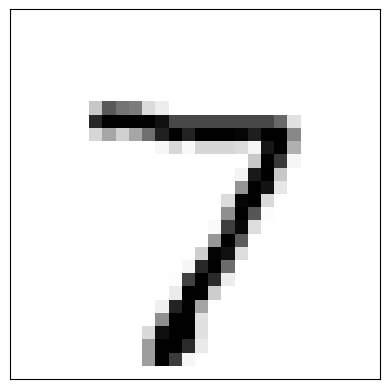

The label is 7
The prediction is 7


In [9]:
index_correct = numpy.where(array_correct == True)[0][0] # Where returns tuple
plt.imshow(x_test[index_correct], cmap='Greys')
plt.xticks([])
plt.yticks([])
plt.show()
print("The label is", y_test_cat[index_correct])
print("The prediction is", predictions[index_correct])

Sometimes we'll get it wrong

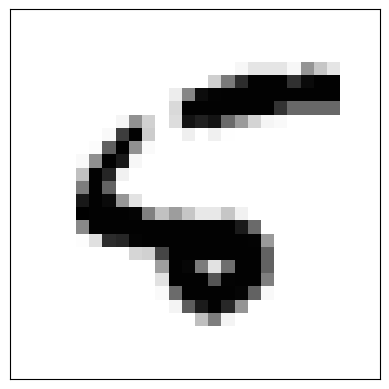

The label is 5
The prediction is 6


In [10]:
index_incorrect = numpy.where(array_correct == False)[0][0] # Where returns tuple
plt.imshow(x_test[index_incorrect], cmap='Greys')
plt.xticks([])
plt.yticks([])
plt.show()
print("The label is", y_test_cat[index_incorrect])
print("The prediction is", predictions[index_incorrect])

## Finding the accuracy of the model on the test set

In [11]:
num_correct = array_correct.sum() # True is 1 and False is 0.
print("The model is correct", num_correct, "times out of", len(y_test_cat))
print("The accuracy is", num_correct/len(y_test_cat))

The model is correct 9561 times out of 10000
The accuracy is 0.9561
